# Ideal Parameter Analysis ($\delta=2.25$, $\tau=0.25$, $\alpha=2$) ($\tau$ out of bounds by a lot)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=0.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

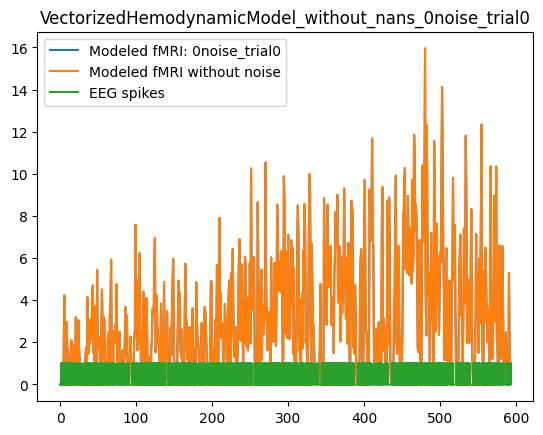

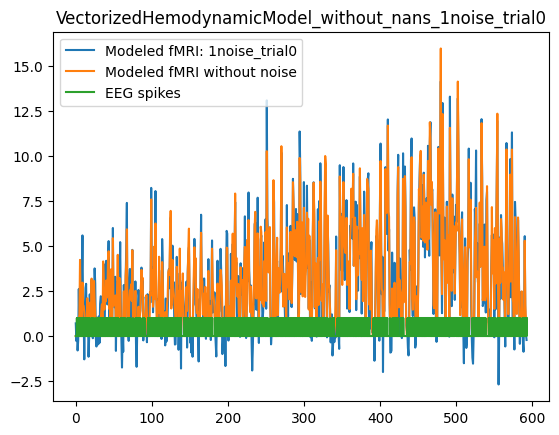

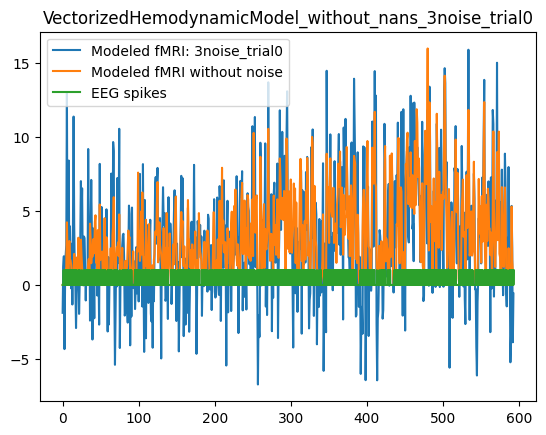

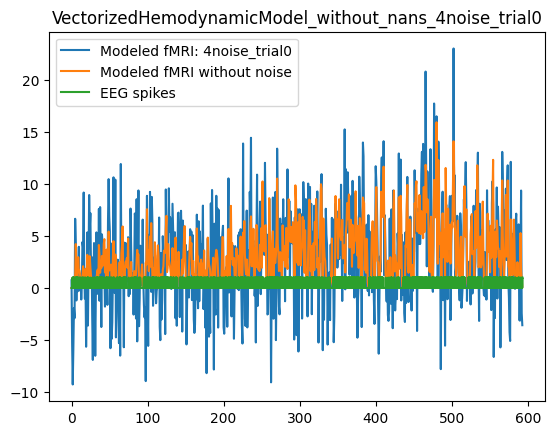

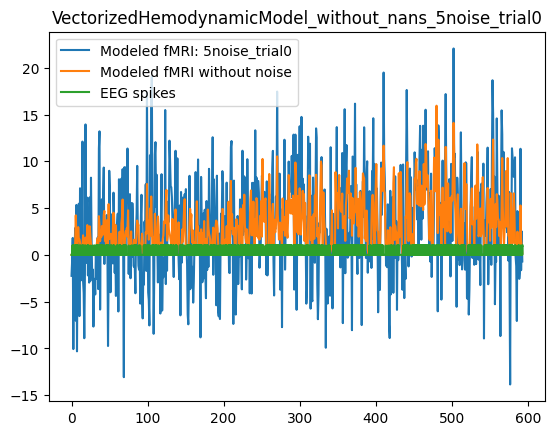

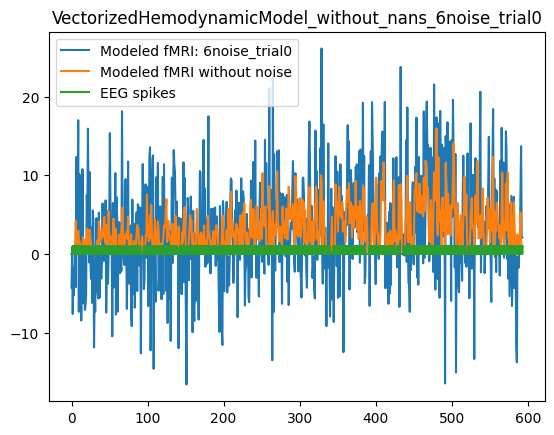

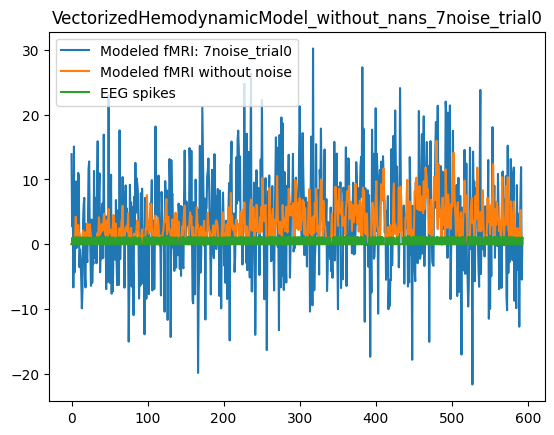

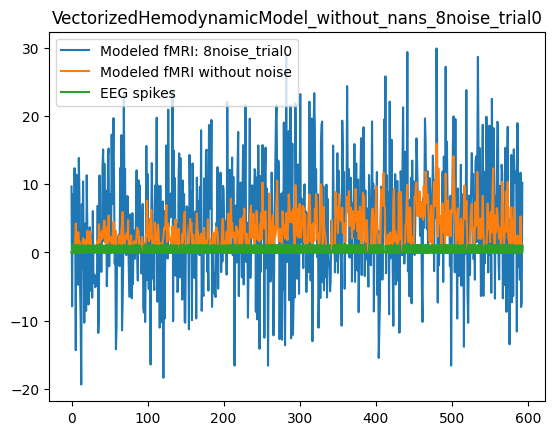

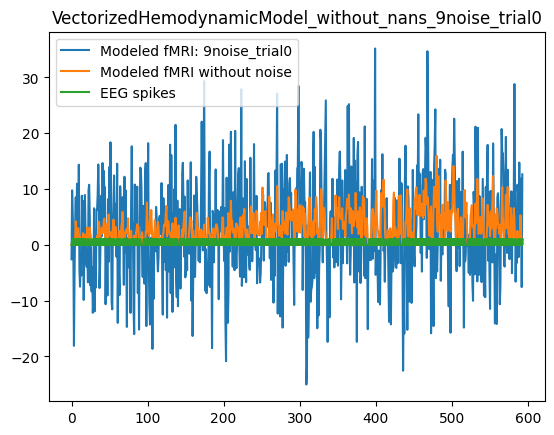

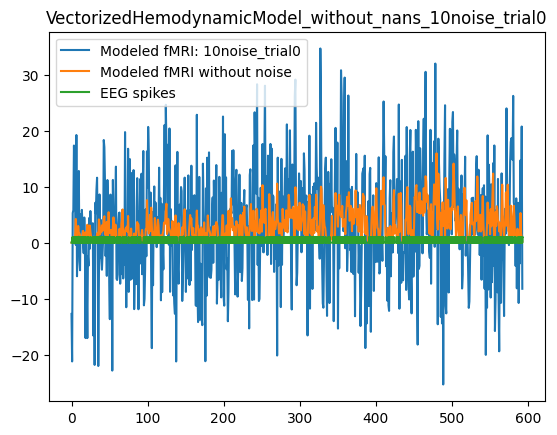

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=0.25, alpha=2


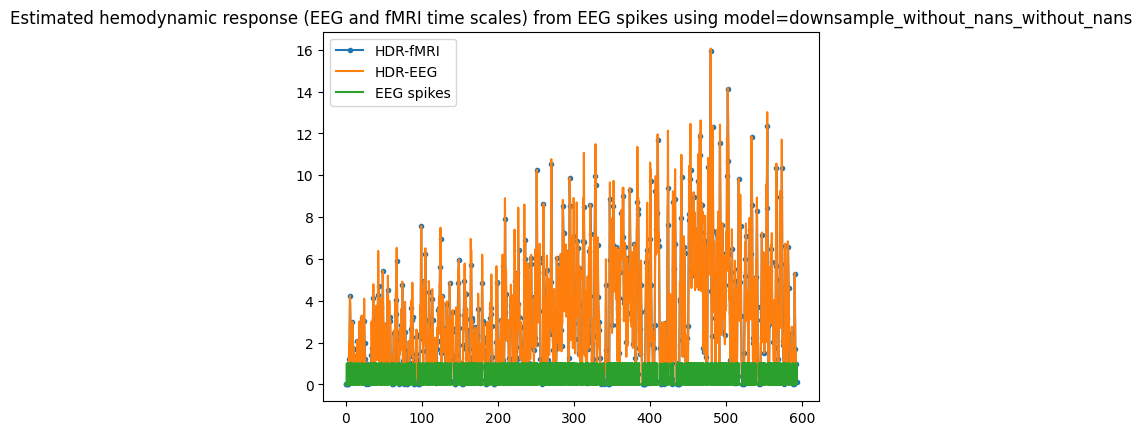

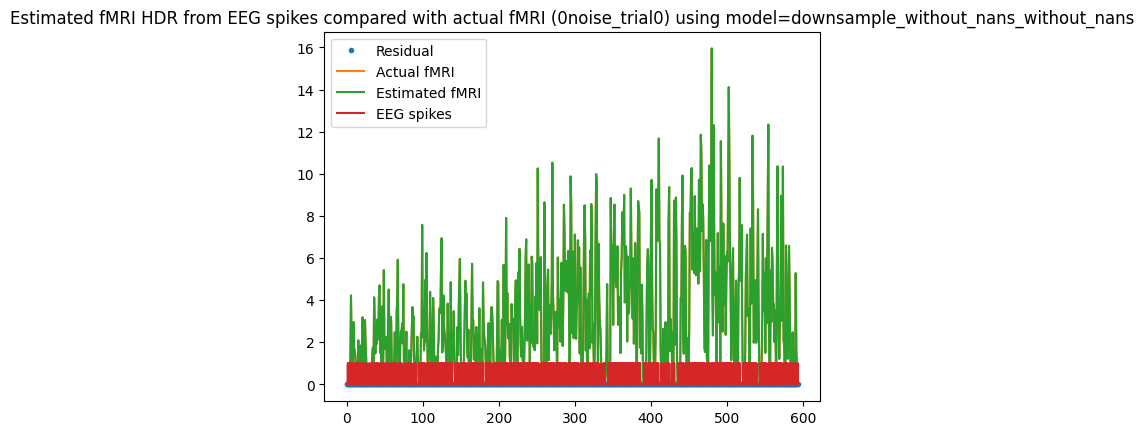

Residual Variance is 0.000000


Residual Variance is 8.730380


Residual Variance is 22.933414


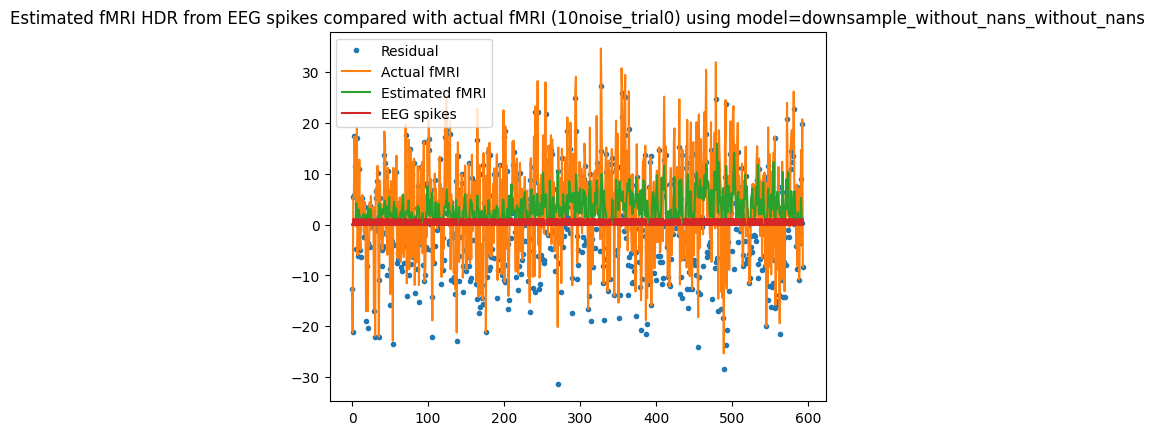

Residual Variance is 92.750432


Scoring downsample_without_nans_with_nans delta=2.25, tau=0.25, alpha=2


Residual Variance is 0.000000


Residual Variance is 7.858496


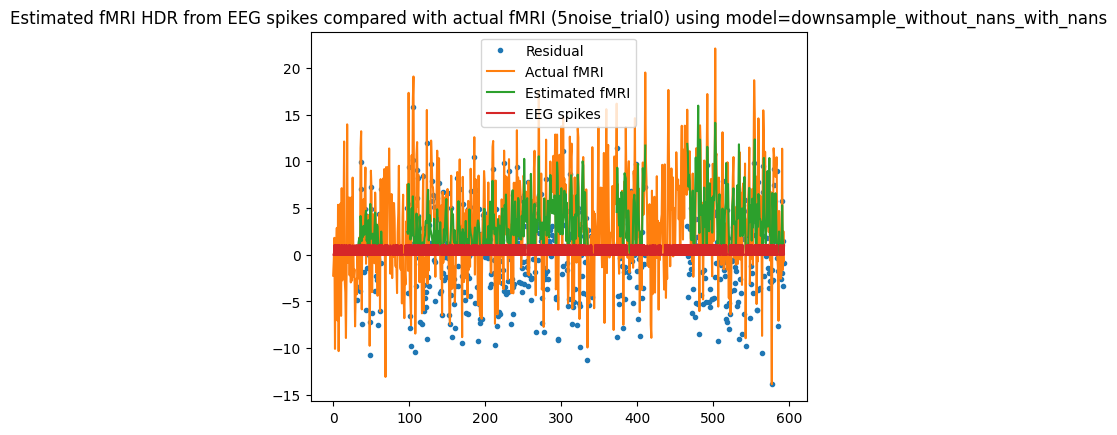

Residual Variance is 22.392413


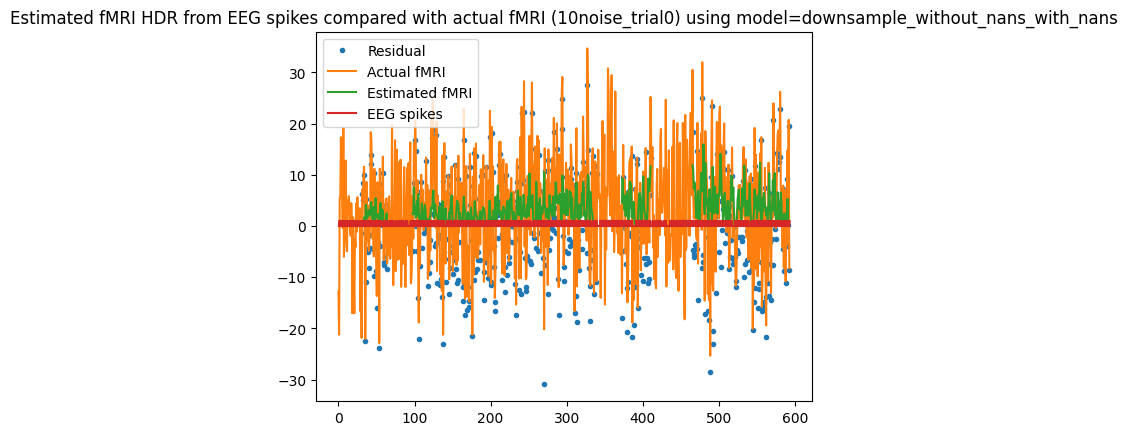

Residual Variance is 92.255439


In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   2.567316328683481   
1         downsample_without_nans_with_nans  2.7403908915487385   
2      downsample_without_nans_without_nans  2.5134285698116856   
3         downsample_without_nans_with_nans  2.6796876472001565   
4      downsample_without_nans_without_nans  2.4658549663754603   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   7.047748927850309   
18938  downsample_without_nans_without_nans   6.905553524614434   
18939     downsample_without_nans_with_nans  7.0486178648725595   
18940  downsample_without_nans_without_nans  6.9086712244974935   
18941     downsample_without_nans_with_nans   7.048984093626606   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0        3.89529803500919    6.12708917045185  11.313362622087515   
1       3.976990515116459    6.30559301457032  10.682826420356902   
2      3.8453470395889884   6.087686010579419  11.271268878964387   
3       3.918723435829677   6.262241332046641  10.624824862609037   
4       3.801823321528823   6.053623805187365  11.234983449071839   
...                   ...                 ...                 ...   
18937   8.389467369501034  10.374555179108079  14.754185475001185   
18938   8.218723513978688  10.129669570753665  15.278752087218974   
18939     8.3886939141827  10.375169154244302  14.755385880480931   
18940   8.219627274058851  10.130323067412798   15.27901477829727   
18941   8.387496360264173  10.375318001320695  14.756180204102701   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      17.028364771087993  25.137641117041156  ...  3.4191370985150673   
1       17.71498263426458  25.192720321357953  ...  3.5838056847576327   
2      16.991670529156934  25.084578086583903  ...   3.370128558928605   
3      17.666342135662756   25.11883494155592  ...  3.5280632037663993   
4      16.961903591630445  25.038392622413767  ...   3.327243851485063   
...                   ...                 ...  ...                 ...   
18937  22.485217725691015   30.34047466473063  ...   7.729511596391422   
18938   21.23672838038655   30.06831204122196  ...   7.656599360488476   
18939  22.481154628603047    30.3414806303928  ...   7.731002609121448   
18940  21.231357396981874   30.06840539931321  ...   7.660508851919636   
18941  22.476762784844123   30.34171225588117  ...   7.732054560479716   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       6.652447061391041  11.595938456606639  16.403760221753974   
1      6.6145449868087836  11.945642226855316  16.758514470590217   
2       6.593550175537182  11.532989192998846  16.380203480707802   
3       6.548898416091245  11.860577819758591  16.740683232310705   
4       6.540640741041812  11.476962765110994  16.362051870385038   
...                   ...                 ...                 ...   
18937  10.858134450632129   16.67532630491436   20.90119603063651   
18938  10.873943866816017  16.025935783090887   20.92918971755956   
18939  10.862292924195556   16.67828793054733  

## No Noise Analysis - downsample without missing data

### Cost

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.964904008698958; at
      delta   tau  alpha
4620    1.5  0.75   1.75


delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                               2.567316             
2                                               2.513429             
4                                               2.465855             
6                                               2.424622             
8                                               2.389732             
...                                                  ...             
18932                                           6.892514             
18934                                           6.897517             
18936                                           6.901849             
18938                                           6.905554             
18940                                           6.908671             

[9471 rows x 4 columns]

In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.25, Alpha target: 2


delta   tau  alpha
0    1.5  0.75   1.75

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  1.964904    1.5  0.75   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration      cost  delta   tau  alpha
0      0         0  1.964904    1.5  0.75   1.75

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
0      0         0  1.964904    1.5  0.75   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.0559237056738286; at
      delta   tau  alpha
4621    1.5  0.75   1.75


delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                               2.740391          
3                                               2.679688          
5                                               2.625727          
7                                               2.578556          
9                                               2.538198          
...                                                  ...          
18933                                           7.044349          
18935                                           7.046340          
18937                                           7.047749          
18939                                           7.048618          
18941                                           7.048984          

[9471 rows x 4 columns]

In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.25, Alpha target: 2


delta   tau  alpha
0    1.5  0.75   1.75

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  2.055924    1.5  0.75   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration      cost  delta   tau  alpha
0      0         0  2.055924    1.5  0.75   1.75

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
0      0         0  2.055924    1.5  0.75   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 2.9563748599639847; at
      delta   tau  alpha
4620    1.5  0.75   1.75


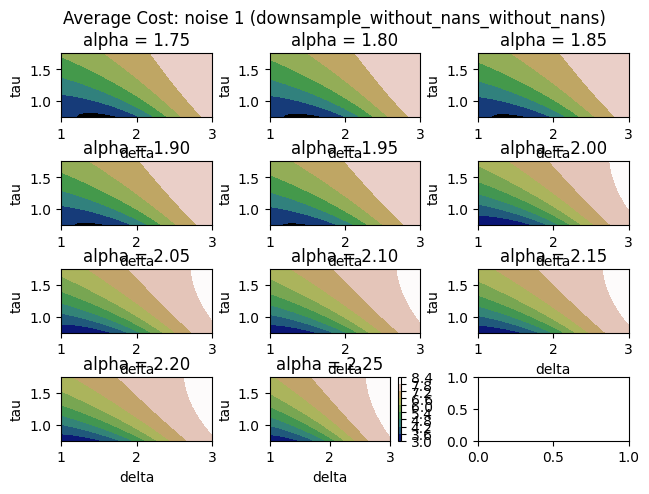

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 5.971464673686196; at
      delta   tau  alpha
4620    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 10.928355961883023; at
      delta   tau  alpha
4620    1.5  0.75   1.75


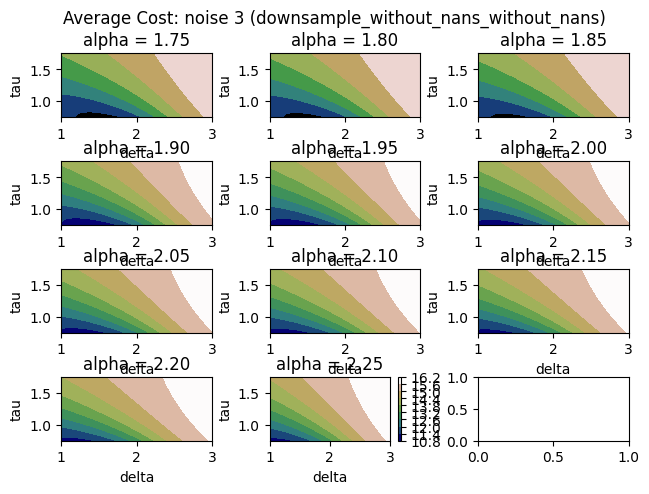

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 17.908974395221126; at
      delta   tau  alpha
4620    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 26.9999437077862; at
      delta   tau  alpha
4620    1.5  0.75   1.75


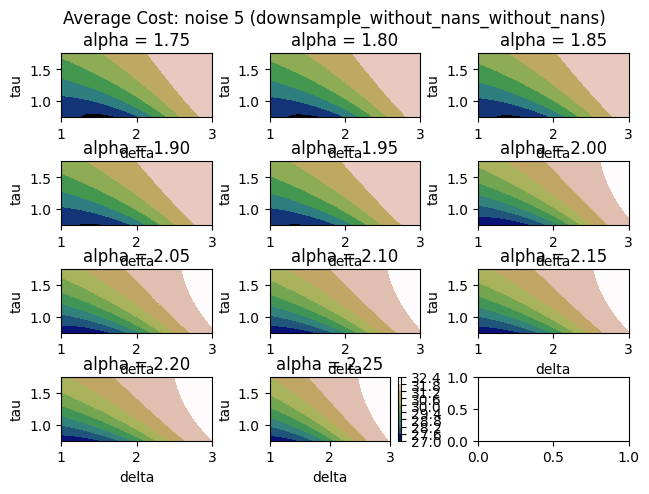

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 38.22526872135151; at
      delta   tau  alpha
4620    1.5  0.75   1.75


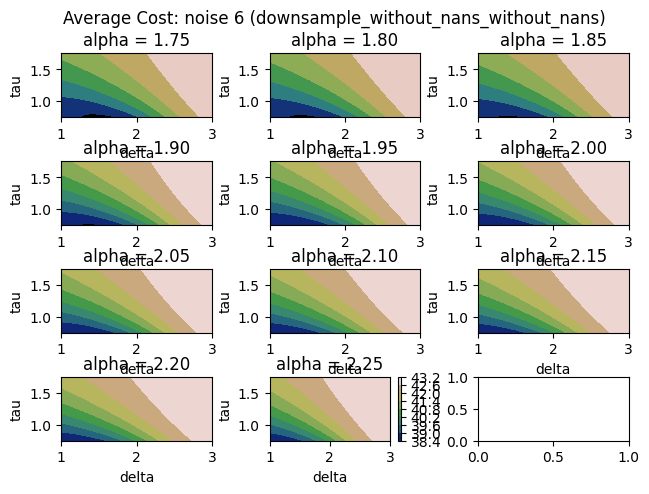

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 50.858934874254864; at
      delta   tau  alpha
4620    1.5  0.75   1.75


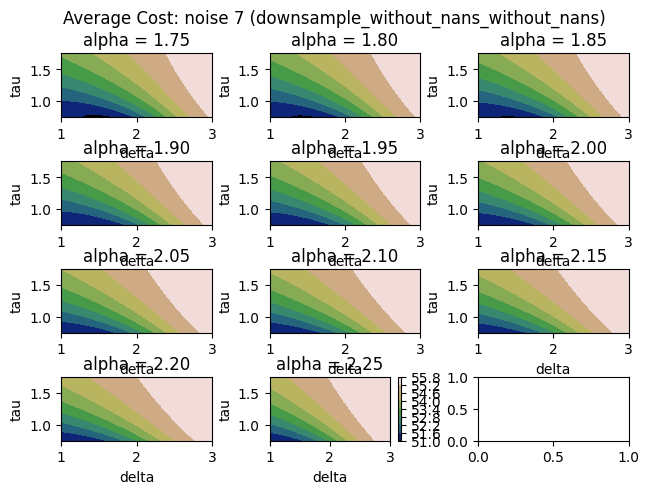

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 65.29573721742412; at
      delta   tau  alpha
4620    1.5  0.75   1.75


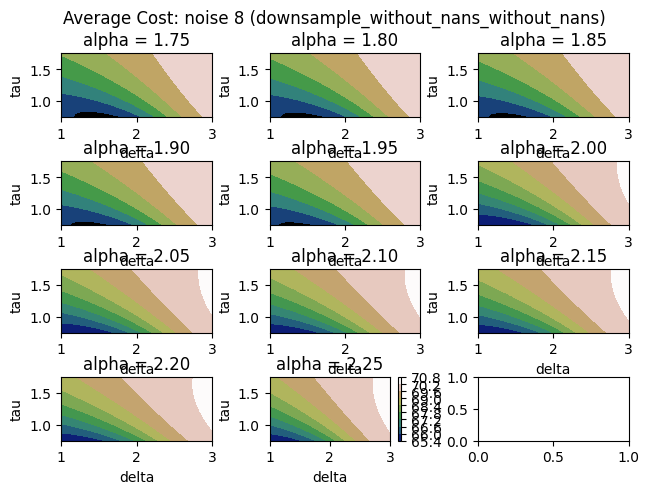

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 82.75563537741508; at
      delta   tau  alpha
4620    1.5  0.75   1.75


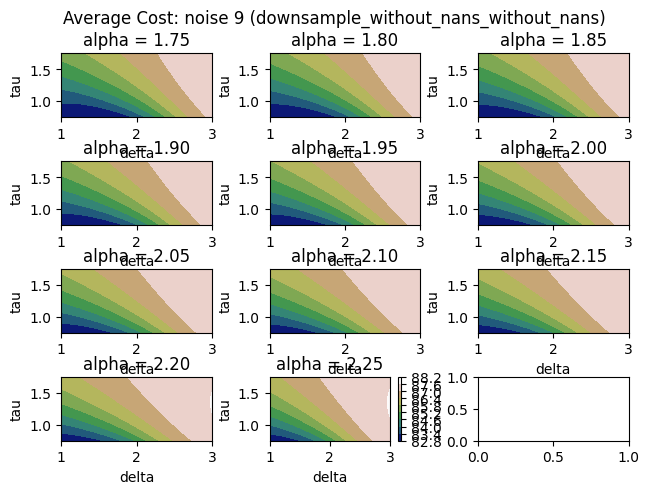

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 101.56141229118077; at
      delta   tau  alpha
4620    1.5  0.75   1.75


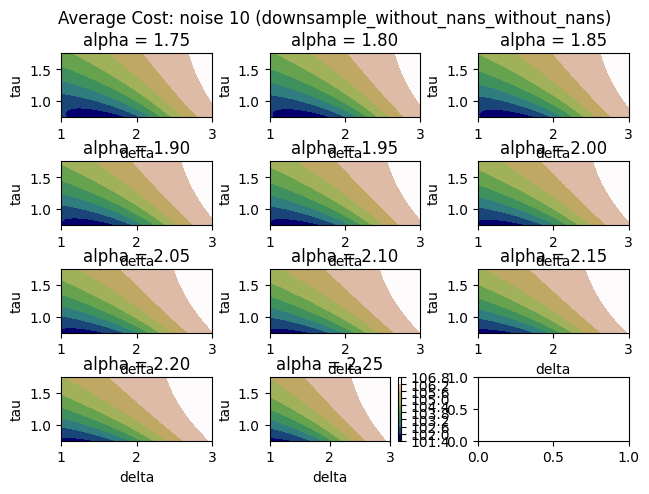

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

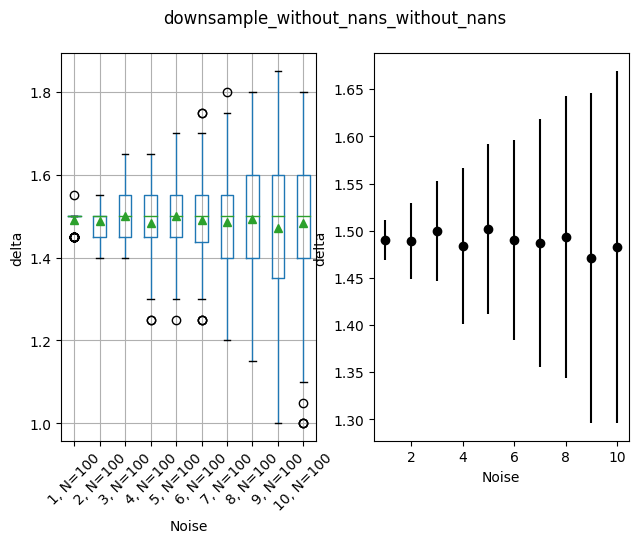

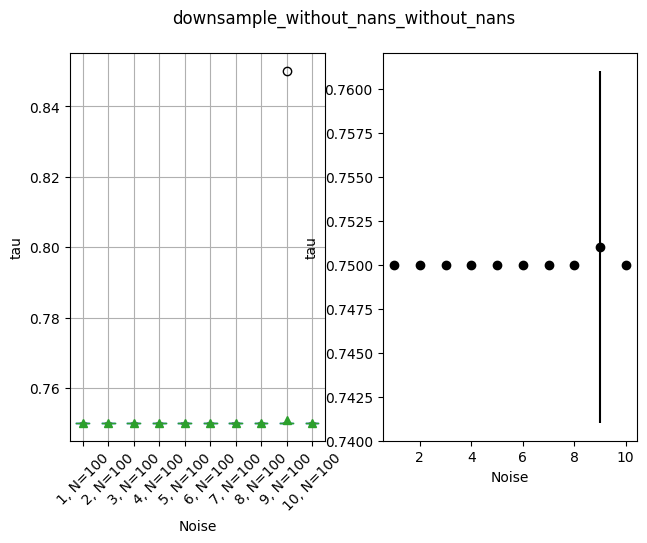

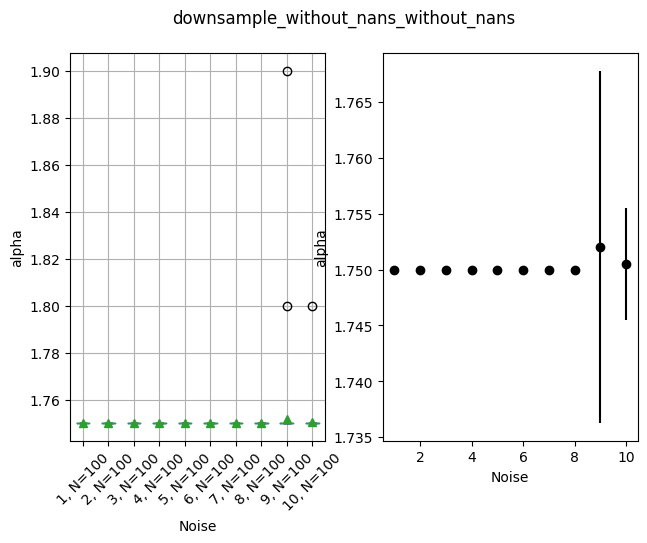

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 3.0555648529990243; at
      delta   tau  alpha
4621    1.5  0.75   1.75


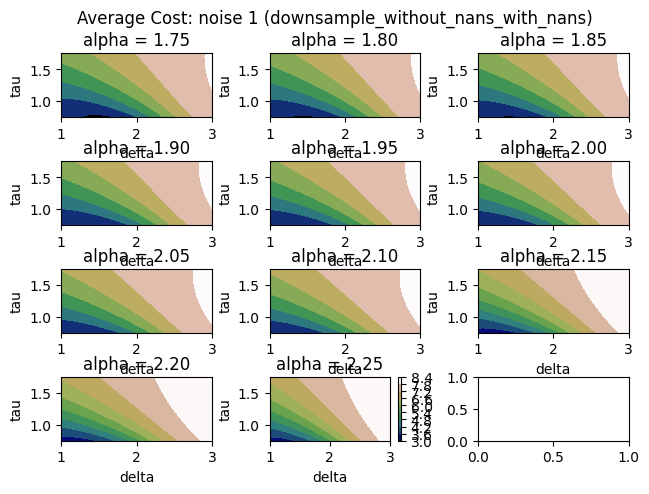

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 6.075335022354708; at
      delta   tau  alpha
4621    1.5  0.75   1.75


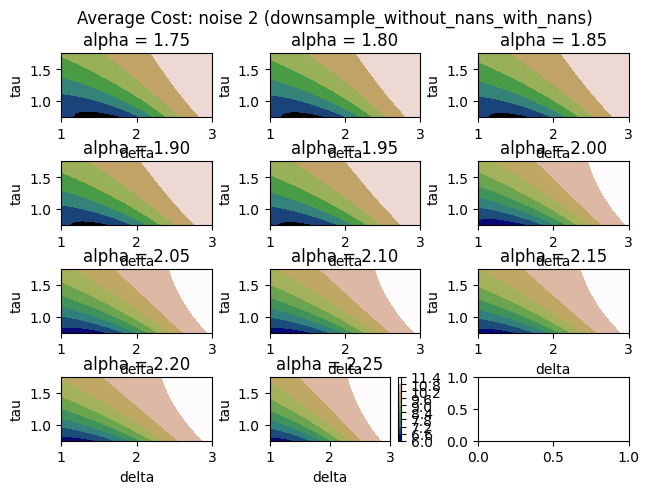

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 10.976233183477548; at
      delta   tau  alpha
4621    1.5  0.75   1.75


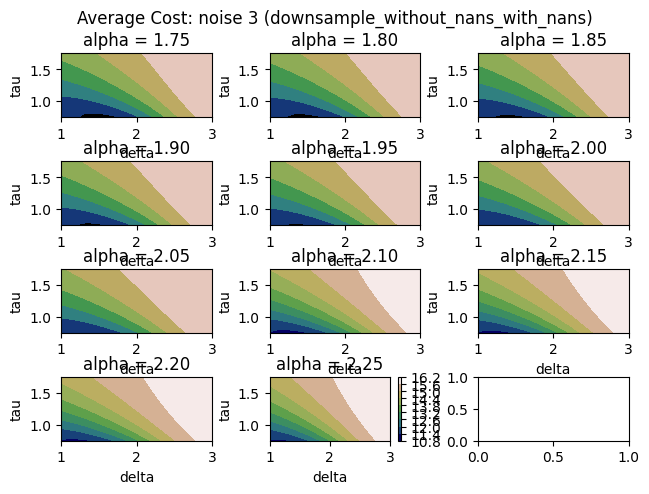

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 18.05582948391764; at
      delta   tau  alpha
4621    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 27.128270689334453; at
      delta   tau  alpha
4621    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 38.371446752924165; at
      delta   tau  alpha
4621    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 50.93804748080418; at
      delta   tau  alpha
4621    1.5  0.75   1.75


Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 65.65901716485283; at
      delta   tau  alpha
4621    1.5  0.75   1.75


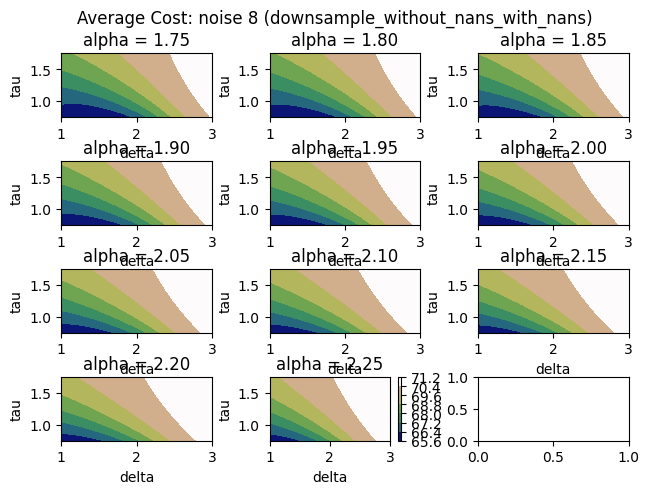

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 82.75891651049643; at
      delta   tau  alpha
4621    1.5  0.75   1.75


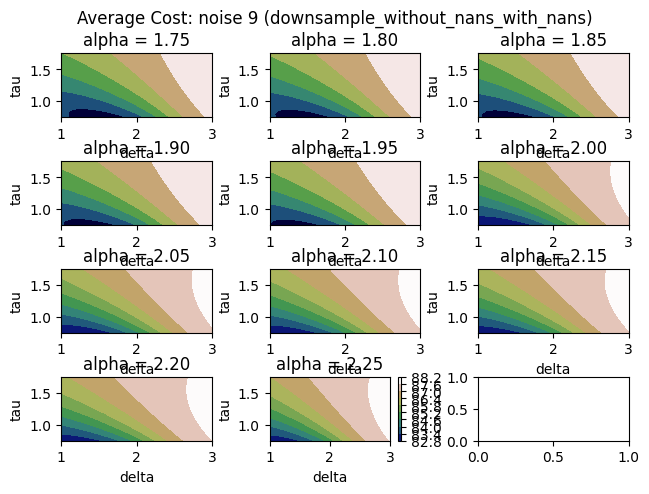

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 101.77913270755963; at
      delta   tau  alpha
4621    1.5  0.75   1.75


In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


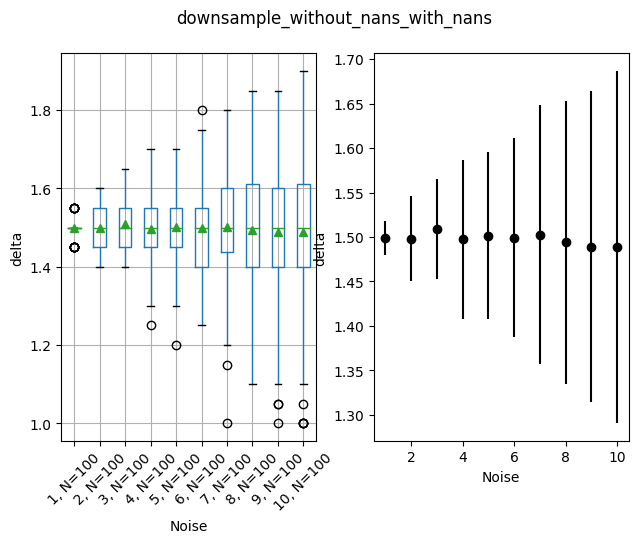

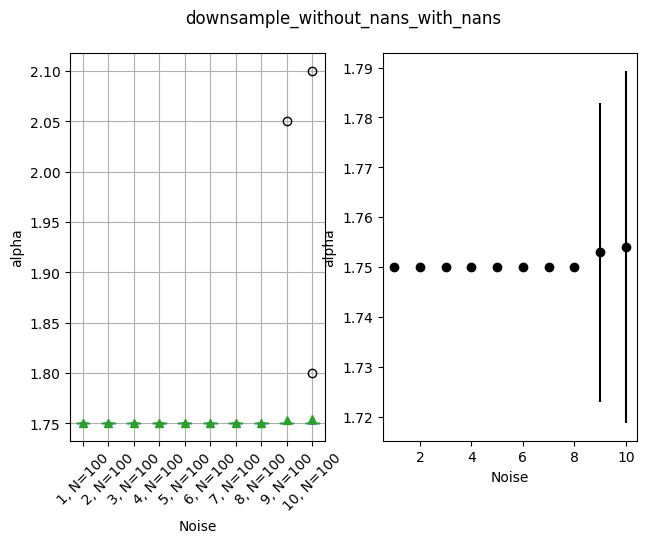

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         3    2.896064  1.4500000000000004                0.75   
1         1         5    2.979696  1.4500000000000004                0.75   
2         1         8    2.896879  1.4500000000000004                0.75   
3         1        10    3.097031  1.4500000000000004                0.75   
4         1        11    2.916249  1.4500000000000004                0.75   
...     ...       ...         ...                 ...                 ...   
1021     10        21   97.413322  3.0000000000000018  1.7500000000000009   
1022     10        32  108.308108  3.0000000000000018  1.7500000000000009   
1023     10        37  107.452936  3.0000000000000018  1.7500000000000009   
1024     10        48  104.492275  3.0000000000000018  1.7500000000000009   
1025     10        56   99.511913  3.0000000000000018  1.7500000000000009   

                   alpha  
0                   1.75  
1                   1.75  
2                   1.75  
3                   1.75  
4                   1.75  
...                  ...  
1021  2.2500000000000004  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004  

[1026 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
4                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
5                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
6                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
7                      100.0  1.02  0.140705  1.0  1.0  1.0  1.0  2.0
8                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
9                      100.0  1.12  0.356186  1.0  1.0  1.0  1.0  3.0
10                     100.0  1.10  0.301511  1.0  1.0  1.0  1.0  2.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau               alpha
804      9        84   81.645917   1.0                0.75                1.75
805      9        72   78.292833   1.0                0.75  2.1000000000000005
806      9        72   78.288855   1.0                 0.8  1.9500000000000002
807      9        72   78.287002   1.0  0.8500000000000001                 1.8
916     10        21   93.743710   1.0                0.75                1.75
917     10        41   99.014404   1.0                0.75                1.75
918     10        83  108.663703   1.0                0.75                 1.8
919     10        31   92.096787   1.0                0.75  2.0500000000000003

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
600       6        35   43.824886  3.0000000000000018  1.7500000000000009   
701       7        13   55.280320  3.0000000000000018  1.7500000000000009   
702       7        79   52.908217  3.0000000000000018  1.7500000000000009   
803       8         2   67.704391  3.0000000000000018  1.7500000000000009   
906       9        90   90.252825  3.0000000000000018  1.2000000000000004   
907       9        13   84.409693  3.0000000000000018  1.7500000000000009   
908       9        45   91.578610  3.0000000000000018  1.7500000000000009   
909       9        46   87.679896  3.0000000000000018  1.7500000000000009   
910       9        61   88.750736  3.0000000000000018  1.7500000000000009   
911       9        66   88.890453  3.0000000000000018  1.7500000000000009   
912       9        75   86.561764  3.0000000000000018  1.7500000000000009   
913       9        84   86.270788  3.0000000000000018  1.7500000000000009   
914       9        94   80.380680  3.0000000000000018  1.7500000000000009   
915       9        98   91.403763  3.0000000000000018  1.7500000000000009   
1017     10        52  113.438325  3.0000000000000018  1.5000000000000007   
1018     10         1  100.506724  3.0000000000000018  1.7500000000000009   
1019     10        17  100.571456  3.0000000000000018  1.7500000000000009   
1020     10        18  103.347857  3.0000000000000018  1.7500000000000009   
1021     10        21   97.413322  3.0000000000000018  1.7500000000000009   
1022     10        32  108.308108  3.0000000000000018  1.7500000000000009   
1023     10        37  107.452936  3.0000000000000018  1.7500000000000009   
1024     10        48  104.492275  3.0000000000000018  1.7500000000000009   
1025     10        56   99.511913  3.0000000000000018  1.7500000000000009   

                   alpha  
600   2.2500000000000004  
701   2.2500000000000004  
702   2.2500000000000004  
803   2.2500000000000004  
906   2.2500000000000004  
907   2.2500000000000004  
908   2.2500000000000004  
909   2.2500000000000004  
910   2.2500000000000004  
911   2.2500000000000004  
912   2.2500000000000004  
913   2.2500000000000004  
914   2.2500000000000004  
915   2.2500000000000004  
1017  2.2500000000000004  
1018  2.2500000000000004  
1019  2.2500000000000004  
1020  2.2500000000000004  
1021  2.2500000000000004  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1         3    2.896064  1.4500000000000004  0.75  1.75
1         1         5    2.979696  1.4500000000000004  0.75  1.75
2         1         8    2.896879  1.4500000000000004  0.75  1.75
3         1        10    3.097031  1.4500000000000004  0.75  1.75
4         1        11    2.916249  1.4500000000000004  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1012     10        96   96.563644  1.7500000000000007  0.75  1.75
1013     10        27   96.836739  1.8000000000000007  0.75  1.75
1014     10        53  103.719211  1.8000000000000007  0.75  1.75
1015     10        64  101.760670  1.8000000000000007  0.75  1.75
1016     10        88  106.951175  1.8000000000000007  0.75  1.75

[1001 rows x 6 columns]

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
600       6        35   43.824886  3.0000000000000018  1.7500000000000009   
701       7        13   55.280320  3.0000000000000018  1.7500000000000009   
702       7        79   52.908217  3.0000000000000018  1.7500000000000009   
803       8         2   67.704391  3.0000000000000018  1.7500000000000009   
907       9        13   84.409693  3.0000000000000018  1.7500000000000009   
908       9        45   91.578610  3.0000000000000018  1.7500000000000009   
909       9        46   87.679896  3.0000000000000018  1.7500000000000009   
910       9        61   88.750736  3.0000000000000018  1.7500000000000009   
911       9        66   88.890453  3.0000000000000018  1.7500000000000009   
912       9        75   86.561764  3.0000000000000018  1.7500000000000009   
913       9        84   86.270788  3.0000000000000018  1.7500000000000009   
914       9        94   80.380680  3.0000000000000018  1.7500000000000009   
915       9        98   91.403763  3.0000000000000018  1.7500000000000009   
1018     10         1  100.506724  3.0000000000000018  1.7500000000000009   
1019     10        17  100.571456  3.0000000000000018  1.7500000000000009   
1020     10        18  103.347857  3.0000000000000018  1.7500000000000009   
1021     10        21   97.413322  3.0000000000000018  1.7500000000000009   
1022     10        32  108.308108  3.0000000000000018  1.7500000000000009   
1023     10        37  107.452936  3.0000000000000018  1.7500000000000009   
1024     10        48  104.492275  3.0000000000000018  1.7500000000000009   
1025     10        56   99.511913  3.0000000000000018  1.7500000000000009   

                   alpha  
600   2.2500000000000004  
701   2.2500000000000004  
702   2.2500000000000004  
803   2.2500000000000004  
907   2.2500000000000004  
908   2.2500000000000004  
909   2.2500000000000004  
910   2.2500000000000004  
911   2.2500000000000004  
912   2.2500000000000004  
913   2.2500000000000004  
914   2.2500000000000004  
915   2.2500000000000004  
1018  2.2500000000000004  
1019  2.2500000000000004  
1020  2.2500000000000004  
1021  2.2500000000000004  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1         3    2.896064  1.4500000000000004  0.75  1.75
1         1         5    2.979696  1.4500000000000004  0.75  1.75
2         1         8    2.896879  1.4500000000000004  0.75  1.75
3         1        10    3.097031  1.4500000000000004  0.75  1.75
4         1        11    2.916249  1.4500000000000004  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1012     10        96   96.563644  1.7500000000000007  0.75  1.75
1013     10        27   96.836739  1.8000000000000007  0.75  1.75
1014     10        53  103.719211  1.8000000000000007  0.75  1.75
1015     10        64  101.760670  1.8000000000000007  0.75  1.75
1016     10        88  106.951175  1.8000000000000007  0.75  1.75

[997 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1       100      3  1.5000000000000004   78   100      1  0.75  100
10       99     17  1.5000000000000004   13    99      1  0.75   99
2       100      4  1.5000000000000004   42   100      1  0.75  100
3       100      6  1.5000000000000004   36   100      1  0.75  100
4       100      9  1.5000000000000004   25   100      1  0.75  100
5       100     10  1.5000000000000004   21   100      1  0.75  100
6       100     11  1.5000000000000004   23   100      1  0.75  100
7       100     13  1.5000000000000004   18   100      1  0.75  100
8       100     14  1.4500000000000004   16   100      1  0.75  100
9        98     17  1.3500000000000003   14    98      1  0.75   98

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
600       6        35   43.824886  3.0000000000000018  1.7500000000000009   
701       7        13   55.280320  3.0000000000000018  1.7500000000000009   
702       7        79   52.908217  3.0000000000000018  1.7500000000000009   
803       8         2   67.704391  3.0000000000000018  1.7500000000000009   
906       9        90   90.252825  3.0000000000000018  1.2000000000000004   
907       9        13   84.409693  3.0000000000000018  1.7500000000000009   
908       9        45   91.578610  3.0000000000000018  1.7500000000000009   
909       9        46   87.679896  3.0000000000000018  1.7500000000000009   
910       9        61   88.750736  3.0000000000000018  1.7500000000000009   
911       9        66   88.890453  3.0000000000000018  1.7500000000000009   
912       9        75   86.561764  3.0000000000000018  1.7500000000000009   
913       9        84   86.270788  3.0000000000000018  1.7500000000000009   
914       9        94   80.380680  3.0000000000000018  1.7500000000000009   
915       9        98   91.403763  3.0000000000000018  1.7500000000000009   
1017     10        52  113.438325  3.0000000000000018  1.5000000000000007   
1018     10         1  100.506724  3.0000000000000018  1.7500000000000009   
1019     10        17  100.571456  3.0000000000000018  1.7500000000000009   
1020     10        18  103.347857  3.0000000000000018  1.7500000000000009   
1021     10        21   97.413322  3.0000000000000018  1.7500000000000009   
1022     10        32  108.308108  3.0000000000000018  1.7500000000000009   
1023     10        37  107.452936  3.0000000000000018  1.7500000000000009   
1024     10        48  104.492275  3.0000000000000018  1.7500000000000009   
1025     10        56   99.511913  3.0000000000000018  1.7500000000000009   

                   alpha  
600   2.2500000000000004  
701   2.2500000000000004  
702   2.2500000000000004  
803   2.2500000000000004  
906   2.2500000000000004  
907   2.2500000000000004  
908   2.2500000000000004  
909   2.2500000000000004  
910   2.2500000000000004  
911   2.2500000000000004  
912   2.2500000000000004  
913   2.2500000000000004  
914   2.2500000000000004  
915   2.2500000000000004  
1017  2.2500000000000004  
1018  2.2500000000000004  
1019  2.2500000000000004  
1020  2.2500000000000004  
1021  2.2500000000000004  
1022  2.2500000000000004  
1023  2.2500000000000004  
1024  2.2500000000000004  
1025  2.2500000000000004

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10        9      1  3.0000000000000018    9     9      2  1.7500000000000009   
6         1      1  3.0000000000000018    1     1      1  1.7500000000000009   
7         2      1  3.0000000000000018    2     2      1  1.7500000000000009   
8         1      1  3.0000000000000018    1     1      1  1.7500000000000009   
9        10      1  3.0000000000000018   10    10      2  1.7500000000000009   

            
      freq  
noise       
10       8  
6        1  
7        2  
8        1  
9        9

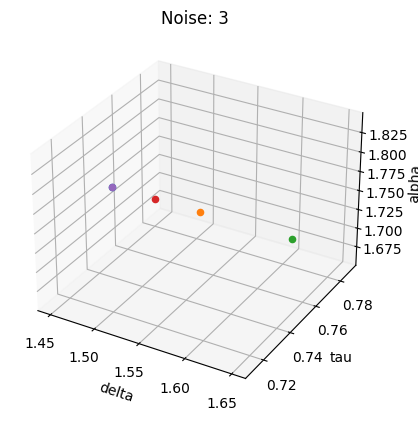

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

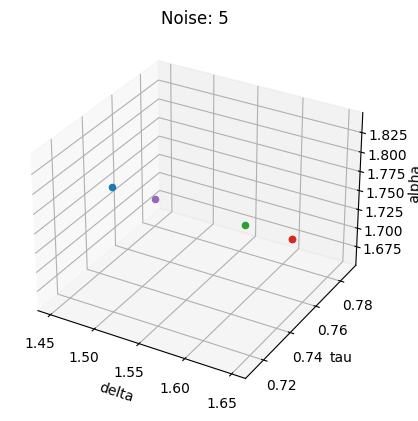

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

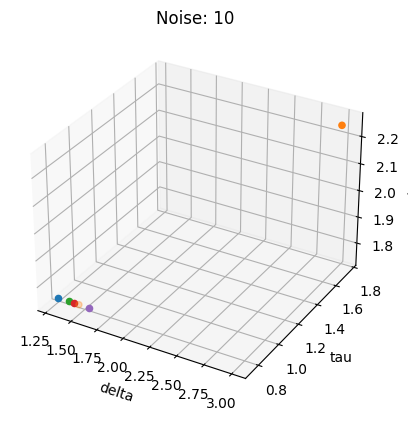

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        11    3.053580  1.4500000000000004                0.75   
1         1        26    3.170986  1.4500000000000004                0.75   
2         1        30    2.978755  1.4500000000000004                0.75   
3         1        42    2.909937  1.4500000000000004                0.75   
4         1        68    3.152942  1.4500000000000004                0.75   
...     ...       ...         ...                 ...                 ...   
1054     10        46  108.264671  3.0000000000000018  1.7500000000000009   
1055     10        48  107.000974  3.0000000000000018  1.7500000000000009   
1056     10        55  107.604035  3.0000000000000018  1.7500000000000009   
1057     10        66  111.364284  3.0000000000000018  1.7500000000000009   
1058     10        80  102.354462  3.0000000000000018  1.7500000000000009   

                   alpha  
0                   1.75  
1                   1.75  
2                   1.75  
3                   1.75  
4                   1.75  
...                  ...  
1054  2.2500000000000004  
1055  2.2500000000000004  
1056  2.2500000000000004  
1057  2.2500000000000004  
1058  2.2500000000000004  

[1059 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
4                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
5                      100.0  1.01  0.100000  1.0  1.0  1.0  1.0  2.0
6                      100.0  1.03  0.171447  1.0  1.0  1.0  1.0  2.0
7                      100.0  1.07  0.293189  1.0  1.0  1.0  1.0  3.0
8                      100.0  1.10  0.301511  1.0  1.0  1.0  1.0  2.0
9                      100.0  1.18  0.435310  1.0  1.0  1.0  1.0  3.0
10                     100.0  1.20  0.449467  1.0  1.0  1.0  1.0  3.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau               alpha
604      7        98   45.455984   1.0                0.75                1.75
821      9        72   73.246208   1.0                 0.8                1.75
939     10        41   99.405533   1.0                0.75                1.75
940     10        66  105.454146   1.0                0.75                1.75
941     10        31   90.284782   1.0                0.75  2.1000000000000005
942     10        31   90.289794   1.0                 0.8  1.9500000000000002
943     10        83  104.339906   1.0  1.1500000000000004                1.75

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
500       5        45   34.049033  3.0000000000000018  1.7500000000000009   
601       6        71   47.040891  3.0000000000000018  1.6500000000000008   
602       6        35   45.393645  3.0000000000000018  1.7500000000000009   
603       6        92   40.943943  3.0000000000000018  1.7500000000000009   
704       7         4   57.383236  3.0000000000000018  0.9000000000000001   
705       7        24   58.280504  3.0000000000000018  1.4000000000000006   
706       7         4   57.339489  3.0000000000000018  1.7500000000000009   
707       7        13   56.663681  3.0000000000000018  1.7500000000000009   
708       7        35   57.584454  3.0000000000000018  1.7500000000000009   
709       7        52   56.358753  3.0000000000000018  1.7500000000000009   
710       7        79   54.163335  3.0000000000000018  1.7500000000000009   
811       8         2   69.261441  3.0000000000000018  1.7500000000000009   
812       8        11   64.567159  3.0000000000000018  1.7500000000000009   
813       8        35   71.411709  3.0000000000000018  1.7500000000000009   
814       8        41   65.800962  3.0000000000000018  1.7500000000000009   
815       8        44   69.129846  3.0000000000000018  1.7500000000000009   
816       8        51   74.991934  3.0000000000000018  1.7500000000000009   
817       8        55   72.866155  3.0000000000000018  1.7500000000000009   
818       8        62   65.931470  3.0000000000000018  1.7500000000000009   
819       8        80   66.420679  3.0000000000000018  1.7500000000000009   
820       8        86   66.102733  3.0000000000000018  1.7500000000000009   
922       9        46   81.874361  3.0000000000000018                0.75   
923       9        94   83.102482  3.0000000000000018  1.0000000000000002   
924       9        22   85.035359  3.0000000000000018  1.1000000000000003   
925       9        90   88.397836  3.0000000000000018  1.3000000000000005   
926       9        23   83.617748  3.0000000000000018  1.4500000000000006   
927       9        93   90.157194  3.0000000000000018  1.4500000000000006   
928       9        19   93.961994  3.0000000000000018  1.7500000000000009   
929       9        34   84.946534  3.0000000000000018  1.7500000000000009   
930       9        46   81.351870  3.0000000000000018  1.7500000000000009   
931       9        51   79.844240  3.0000000000000018  1.7500000000000009   
932       9        61   88.141740  3.0000000000000018  1.7500000000000009   
933       9        81   84.175499  3.0000000000000018  1.7500000000000009   
934       9        84   86.776487  3.0000000000000018  1.7500000000000009   
935       9        85   81.500944  3.0000000000000018  1.7500000000000009   
936       9        94   82.970353  3.0000000000000018  1.7500000000000009   
937       9        97   85.199866  3.0000000000000018  1.7500000000000009   
938       9        98   92.786351  3.0000000000000018  1.7500000000000009   
1042     10        32  105.151722  3.0000000000000018                 0.8   
1043     10        80  102.302303  3.0000000000000018  1.0500000000000003   
1044     10        23  105.681994  3.0000000000000018  1.2000000000000004   
1045     10        52  110.353003  3.0000000000000018  1.3000000000000005   
1046     10        30  103.857348  3.0000000000000018  1.5500000000000007   
1047     10        40  112.913981  3.0000000000000018  1.6000000000000008   
1048     10         2  104.981870  3.0000000000000018  1.7500000000000009   
1049     10         5  109.806274  3.0000000000000018  1.7500000000000009   
1050     10        17  102.610120  3.0000000000000018  1.7500000000000009   
1051     10        32  105.155240  3.0000000000000018  1.7500000000000009   
1052     10        37  114.563756  3.0000000000000018  1.7500000000000009   
1053     10        38  106.595918  3.0000000000000018  1.7500000000000009   
1054     10        46  108.264671  3.0000000000000018  1.7500000000000009   
10

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1        11    3.053580  1.4500000000000004  0.75  1.75
1         1        26    3.170986  1.4500000000000004  0.75  1.75
2         1        30    2.978755  1.4500000000000004  0.75  1.75
3         1        42    2.909937  1.4500000000000004  0.75  1.75
4         1        68    3.152942  1.4500000000000004  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1037     10        33  106.442799  1.7500000000000007  0.75  1.75
1038     10        53  106.601330  1.7500000000000007  0.75  1.75
1039     10        89  112.581667  1.8000000000000007  0.75  1.75
1040     10        96   94.651720  1.8000000000000007  0.75  1.75
1041     10        88  102.221415  1.9000000000000008  0.75  1.75

[1001 rows x 6 columns]

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
500       5        45   34.049033  3.0000000000000018  1.7500000000000009   
602       6        35   45.393645  3.0000000000000018  1.7500000000000009   
603       6        92   40.943943  3.0000000000000018  1.7500000000000009   
706       7         4   57.339489  3.0000000000000018  1.7500000000000009   
707       7        13   56.663681  3.0000000000000018  1.7500000000000009   
708       7        35   57.584454  3.0000000000000018  1.7500000000000009   
709       7        52   56.358753  3.0000000000000018  1.7500000000000009   
710       7        79   54.163335  3.0000000000000018  1.7500000000000009   
811       8         2   69.261441  3.0000000000000018  1.7500000000000009   
812       8        11   64.567159  3.0000000000000018  1.7500000000000009   
813       8        35   71.411709  3.0000000000000018  1.7500000000000009   
814       8        41   65.800962  3.0000000000000018  1.7500000000000009   
815       8        44   69.129846  3.0000000000000018  1.7500000000000009   
816       8        51   74.991934  3.0000000000000018  1.7500000000000009   
817       8        55   72.866155  3.0000000000000018  1.7500000000000009   
818       8        62   65.931470  3.0000000000000018  1.7500000000000009   
819       8        80   66.420679  3.0000000000000018  1.7500000000000009   
820       8        86   66.102733  3.0000000000000018  1.7500000000000009   
928       9        19   93.961994  3.0000000000000018  1.7500000000000009   
929       9        34   84.946534  3.0000000000000018  1.7500000000000009   
930       9        46   81.351870  3.0000000000000018  1.7500000000000009   
931       9        51   79.844240  3.0000000000000018  1.7500000000000009   
932       9        61   88.141740  3.0000000000000018  1.7500000000000009   
933       9        81   84.175499  3.0000000000000018  1.7500000000000009   
934       9        84   86.776487  3.0000000000000018  1.7500000000000009   
935       9        85   81.500944  3.0000000000000018  1.7500000000000009   
936       9        94   82.970353  3.0000000000000018  1.7500000000000009   
937       9        97   85.199866  3.0000000000000018  1.7500000000000009   
938       9        98   92.786351  3.0000000000000018  1.7500000000000009   
1048     10         2  104.981870  3.0000000000000018  1.7500000000000009   
1049     10         5  109.806274  3.0000000000000018  1.7500000000000009   
1050     10        17  102.610120  3.0000000000000018  1.7500000000000009   
1051     10        32  105.155240  3.0000000000000018  1.7500000000000009   
1052     10        37  114.563756  3.0000000000000018  1.7500000000000009   
1053     10        38  106.595918  3.0000000000000018  1.7500000000000009   
1054     10        46  108.264671  3.0000000000000018  1.7500000000000009   
1055     10        48  107.000974  3.0000000000000018  1.7500000000000009   
1056     10        55  107.604035  3.0000000000000018  1.7500000000000009   
1057     10        66  111.364284  3.0000000000000018  1.7500000000000009   
1058     10        80  102.354462  3.0000000000000018  1.7500000000000009   

                   alpha  
500   2.2500000000000004  
602   2.2500000000000004  
603   2.2500000000000004  
706   2.2500000000000004  
707   2.2500000000000004  
708   2.2500000000000004  
709   2.2500000000000004  
710   2.2500000000000004  
811   2.2500000000000004  
812   2.2500000000000004  
813   2.2500000000000004  
814   2.2500000000000004  
815   2.2500000000000004  
816   2.2500000000000004  
817   2.2500000000000004  
818   2.2500000000000004  
819   2.2500000000000004  
820   2.2500000000000004  
928   2.2500000000000004  
929   2.2500000000000004  
930   2.2500000000000004  
931   2.2500000000000004  
932   2.2500000000000004  
933   2.2500000000000004  
934   2.2500000000000004  
935   2.2500000000000004  
936   2.2500000000000004  
937   2.2500000000000004  
938   2.2500000000000004  
1048  2.2500000000000004  
1049  2.250

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1        11    3.053580  1.4500000000000004  0.75  1.75
1         1        26    3.170986  1.4500000000000004  0.75  1.75
2         1        30    2.978755  1.4500000000000004  0.75  1.75
3         1        42    2.909937  1.4500000000000004  0.75  1.75
4         1        68    3.152942  1.4500000000000004  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1037     10        33  106.442799  1.7500000000000007  0.75  1.75
1038     10        53  106.601330  1.7500000000000007  0.75  1.75
1039     10        89  112.581667  1.8000000000000007  0.75  1.75
1040     10        96   94.651720  1.8000000000000007  0.75  1.75
1041     10        88  102.221415  1.9000000000000008  0.75  1.75

[999 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1       100      3  1.5000000000000004   86   100      1  0.75  100
10       99     18  1.4500000000000004   12    99      2  0.75   98
2       100      5  1.5000000000000004   40   100      1  0.75  100
3       100      6  1.5000000000000004   31   100      1  0.75  100
4       100     10  1.5500000000000005   23   100      1  0.75  100
5       100     10  1.5000000000000004   22   100      1  0.75  100
6       100     12  1.5000000000000004   21   100      1  0.75  100
7       100     15  1.4500000000000004   18   100      1  0.75  100
8       100     16  1.4500000000000004   14   100      1  0.75  100
9       100     18  1.5000000000000004   16   100      2  0.75   98

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
500       5        45   34.049033  3.0000000000000018  1.7500000000000009   
601       6        71   47.040891  3.0000000000000018  1.6500000000000008   
602       6        35   45.393645  3.0000000000000018  1.7500000000000009   
603       6        92   40.943943  3.0000000000000018  1.7500000000000009   
704       7         4   57.383236  3.0000000000000018  0.9000000000000001   
705       7        24   58.280504  3.0000000000000018  1.4000000000000006   
706       7         4   57.339489  3.0000000000000018  1.7500000000000009   
707       7        13   56.663681  3.0000000000000018  1.7500000000000009   
708       7        35   57.584454  3.0000000000000018  1.7500000000000009   
709       7        52   56.358753  3.0000000000000018  1.7500000000000009   
710       7        79   54.163335  3.0000000000000018  1.7500000000000009   
811       8         2   69.261441  3.0000000000000018  1.7500000000000009   
812       8        11   64.567159  3.0000000000000018  1.7500000000000009   
813       8        35   71.411709  3.0000000000000018  1.7500000000000009   
814       8        41   65.800962  3.0000000000000018  1.7500000000000009   
815       8        44   69.129846  3.0000000000000018  1.7500000000000009   
816       8        51   74.991934  3.0000000000000018  1.7500000000000009   
817       8        55   72.866155  3.0000000000000018  1.7500000000000009   
818       8        62   65.931470  3.0000000000000018  1.7500000000000009   
819       8        80   66.420679  3.0000000000000018  1.7500000000000009   
820       8        86   66.102733  3.0000000000000018  1.7500000000000009   
922       9        46   81.874361  3.0000000000000018                0.75   
923       9        94   83.102482  3.0000000000000018  1.0000000000000002   
924       9        22   85.035359  3.0000000000000018  1.1000000000000003   
925       9        90   88.397836  3.0000000000000018  1.3000000000000005   
926       9        23   83.617748  3.0000000000000018  1.4500000000000006   
927       9        93   90.157194  3.0000000000000018  1.4500000000000006   
928       9        19   93.961994  3.0000000000000018  1.7500000000000009   
929       9        34   84.946534  3.0000000000000018  1.7500000000000009   
930       9        46   81.351870  3.0000000000000018  1.7500000000000009   
931       9        51   79.844240  3.0000000000000018  1.7500000000000009   
932       9        61   88.141740  3.0000000000000018  1.7500000000000009   
933       9        81   84.175499  3.0000000000000018  1.7500000000000009   
934       9        84   86.776487  3.0000000000000018  1.7500000000000009   
935       9        85   81.500944  3.0000000000000018  1.7500000000000009   
936       9        94   82.970353  3.0000000000000018  1.7500000000000009   
937       9        97   85.199866  3.0000000000000018  1.7500000000000009   
938       9        98   92.786351  3.0000000000000018  1.7500000000000009   
951      10        12   93.517818  1.2000000000000002                0.75   
1042     10        32  105.151722  3.0000000000000018                 0.8   
1043     10        80  102.302303  3.0000000000000018  1.0500000000000003   
1044     10        23  105.681994  3.0000000000000018  1.2000000000000004   
1045     10        52  110.353003  3.0000000000000018  1.3000000000000005   
1046     10        30  103.857348  3.0000000000000018  1.5500000000000007   
1047     10        40  112.913981  3.0000000000000018  1.6000000000000008   
1048     10         2  104.981870  3.0000000000000018  1.7500000000000009   
1049     10         5  109.806274  3.0000000000000018  1.7500000000000009   
1050     10        17  102.610120  3.0000000000000018  1.7500000000000009   
1051     10        32  105.155240  3.0000000000000018  1.7500000000000009   
1052     10        37  114.563756  3.0000000000000018  1.7500000000000009   
1053     10        38  106.595918  3.0000000000000018  1.7500000000000009   
10

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10       18      2  3.0000000000000018   17    18      8  1.7500000000000009   
5         1      1  3.0000000000000018    1     1      1  1.7500000000000009   
6         3      1  3.0000000000000018    3     3      2  1.7500000000000009   
7         7      1  3.0000000000000018    7     7      3  1.7500000000000009   
8        10      1  3.0000000000000018   10    10      1  1.7500000000000009   
9        17      1  3.0000000000000018   17    17      6  1.7500000000000009   

            
      freq  
noise       
10      11  
5        1  
6        2  
7        5  
8       10  
9       11

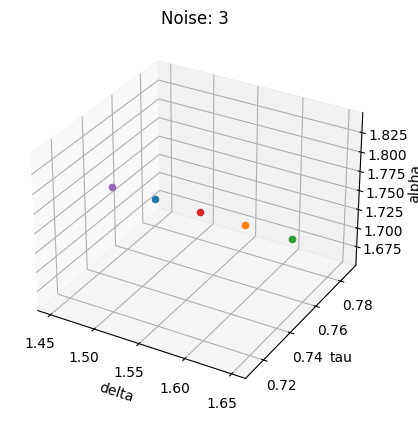

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

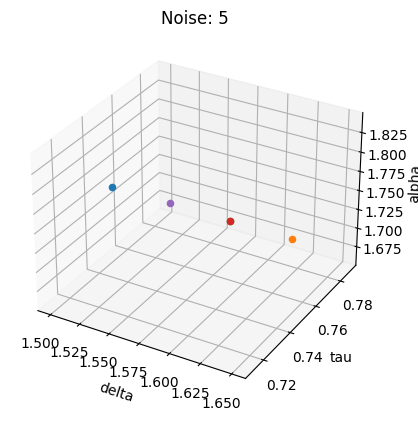

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

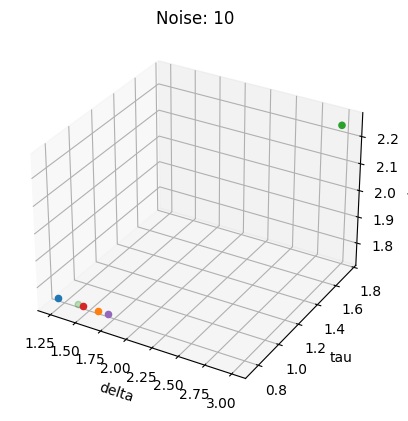

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()